In [8]:
# -*- coding: utf-8 -*-
"""
Created on Thu Jun  10.2020

6-1-1-BiClsMLP-NewsCIS-PreTrain

@author: Johnson

"""
import csv
import logging
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM
from numpy import asarray 
from numpy import zeros
import matplotlib.pyplot as plt

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

## Step 1: Read KCC Cis and News data
### read train data form labeled file and verify data from no labeled file
### dump labeled data into train list and test list form labeled file
### dump no labeled data into verify data list

In [9]:
# csvIn = open("mis Data/2-CIS150_Only3rd_Seg.csv", 'r', newline='', encoding='utf-8-sig')
# csvVerify = open("mis Data/2-CIS150Test_Seg.csv", 'r', newline='', encoding='utf-8-sig')

csvIn = open("News-CIS Data/WS Out/CkipNewsCisLabel-KccDict2020-NoSynonym.txt", 'r', newline='', encoding='utf-8-sig')
csvVerify = open("News-CIS Data/WS Out/CkipNewsCisNoLabel-KccDict2020-NoSynonym.txt", 'r', newline='', encoding='utf-8-sig')
rowlists = csv.reader(csvIn)        # read train data 6,000 records with label)
rowVf = csv.reader(csvVerify)       # read verify data (18,867 records no label)
    
trnCunt = 0
tsCunt = 0
trainTx = []         # text list for train data
trainLabel = []      # binary label(0,1) list for train data
trainCatLabel = []   # multiclass label(類別) list for train data
testTx = []          # text list for test data
testLabel = []       # binary label(0,1) list for test data
testCatLabel = []    # multiclass label(類別) list for test data

for row in rowlists:
   # print(row[0]+": "+ row[1]+": "+row[2])
   # print("================================================")
   if (row[3] == "1" or row[3] == "0") and (len(row[4]) > 50) and trnCunt < 4000:
       # dump first 400 records for train from train data into list trainCatLabel, trainLabel, trainTx
       trainCatLabel.append(int(row[2]))
       trainLabel.append(int(row[3]))
       trainTx.append(row[4])
       trnCunt += 1
   elif (row[3] == "1" or row[3] == "0") and (len(row[4]) > 50) and tsCunt < 1900:
       # dump last 2000 records for test from train data into list 
       testCatLabel.append(int(row[2])) 
       testLabel.append(int(row[3]))
       testTx.append(row[4])
       tsCunt += 1
   if trnCunt > 3999 and tsCunt > 1899 :
       break
csvIn.close()

print("訓練資料筆數: ",trnCunt)
print("multiclass label[100:105] = ",trainCatLabel[100:105])
print("binary label[100:105] = ",trainLabel[100:105])

print("測試資料筆數: ",tsCunt)
print("multiclass label[100:105] = ",testCatLabel[100:105])
print("binary label[100:105] = ",testLabel[100:105])

vfTx = []
for rowV in rowVf:
    # dump text data for verifing from csvVerify file(without label) into list
    if len(rowV[4]) > 50:
        vfTx.append(rowV[4])
    
csvVerify.close()
print("")
print("驗證資料 vfTx 筆數: ",len(vfTx))
print("vfTx[10] = ",vfTx[10])
print("---------------------------------------------")

訓練資料筆數:  4000
multiclass label[100:105] =  [54, 58, 17, 69, 16]
binary label[100:105] =  [0, 0, 0, 0, 0]
測試資料筆數:  1900
multiclass label[100:105] =  [34, 71, 14, 30, 32]
binary label[100:105] =  [1, 1, 1, 0, 0]

驗證資料 vfTx 筆數:  18630
vfTx[10] =  市 議員林武忠 昨天 質詢 呼籲 經發局 應 會展 產業 發展 林 議員 指出 會展 產業 觀光 旅遊 產業 要素 包含 會議 獎勵 旅遊 大型 國際 會議 展覽 貿易 服務 資訊 科技 污染 服務業 視為 國家經濟 發達 程度 指標 高雄 會展 產業 起步 晚 世界 國 城市 發展 推動 排名 稍嫌 落後 近年 市府 推動 ＩＣＣＡ 公布 二○一五年 國際 會議 城市 中 排行 亞洲 第十七 名 相較 台北市 第五 名 空間 林 議員 藉由 ＳＷＯＴ 分析 高雄市 會展 產業 環境 高雄市 會展 產業 發展 潛力 林武忠 建議 經發局 應 會展 辦公室 改為 展 產業 處 提高 層級 人力 會展 業務 推動 專責化 專業化 應 提高 補助 會展 獎勵金 設立 會展 產業 發展 基金 推動 會展 產業 發展 高雄 具 競爭力 在地 產業 遊艇 展 扣件 展 建材展 機械展 法人 團體 合作 藉 培養 定期 專業 展覽 經發局 二○二○年 國際 會議 協會 ＩＣＣＡ 年會 主辦權 世界 國 高雄 推動 會展 產業 軟硬 實力 企圖心 行銷 高雄 帶動 會展 產業 產業 發展 經發局 曾文生局長 高雄市 發展 會展 產業 確實 起步 高雄展覽館 啟用 進展 中 林 議員 提到 獎勵 補助 市府 會展 作 相關 配合 設立 會展 產業 發展 基金 趨勢 經發局 努力 方向 參考 台北 做法 議會 支持
---------------------------------------------


## Step 2: 設定常用字詞典並編碼
###  設定常用字詞典, 並以 trainTx 內容進行編碼

In [10]:

# vocab_size = 20000
# token = Tokenizer(num_words = vocab_size)
token = Tokenizer()

token.fit_on_texts(trainTx)
vocab_size = len(token.word_index) + 1 

print("Total document_count = ", token.document_count)
print("vocab_size = ", vocab_size)

Total document_count =  4000
vocab_size =  59332


## Step 3. 文字轉數字
### 將 token 載入的文件轉為數字 list, 並切齊長度

In [11]:
print("==============  texts_to_sequences  ===========================")
x_train_seq = token.texts_to_sequences(trainTx)
x_test_seq = token.texts_to_sequences(testTx)
print("trainTx[10] = ",trainTx[10])
print("")
print("x_train_seq[10] = ",x_train_seq[10])
print("--------------- pad_sequences ---------------------------------")

# max_length = 300
max_length = 500
# max_length = 1000

x_train = sequence.pad_sequences(x_train_seq, maxlen=max_length, padding='post')
print("x_train[10] = ",x_train[10])
print("")
x_test = sequence.pad_sequences(x_test_seq, maxlen=max_length, padding='post')
print("x_test[10] = ",x_test[10])

==============  texts_to_sequences  ===========================
trainTx[10] =  高雄市政府農業局 昨日 組團 參加 四月 十二日 十五日 新加坡 國際 博覽 中心 二零一六 新加坡 國際食品展 展 一九七八年 創辦 享有 亞洲 食品 酒店業 盛會 稱 參展 廠商 多達 三千 家 吸引 九十七 國家 買主 參觀 開拓 亞太地區 食品 市場 展覽會 農業局 次 邀請型 農 農民 團體 友善 企業 組團 參展 藉由 轉口 貿易 發達 新加坡 打開 高雄 優質 農產 東協 十國 大門 高雄市 農產品 玉荷包 荔枝 蜜棗 番石榴 鳳梨 水果 品質 優良 研發 玉荷包 啤酒 水果 酵素 農產 加工品 東南亞 地區 盛產 熱帶 水果 部份 高雄市 產品 重疊 高雄 農民 擁有 精緻 栽培 技術 產 蔬果 農藥 殘留 產銷 履歷 認證 搭配 創新 加工 技術 發展 農產 加工品 受 農產品 產期 具 具 附加價 高雄 首選 品牌 東南亞 地區 農產品 做 市場 區隔 農業局 面對 農 畜牧 業 走向 全球化 帶來 競爭 高雄市政府 農民 早已 做好 高雄 首選 品牌 立足 台灣 放眼 世界 帶領 高雄 物產 從在地 走向 國際 開發 多元 市場

x_train_seq[10] =  [5312, 412, 3877, 127, 815, 2593, 2152, 1238, 152, 14854, 140, 11011, 1238, 7121, 1917, 32767, 9493, 3995, 1512, 997, 32768, 4110, 1153, 2085, 214, 2647, 1698, 91, 328, 32769, 260, 8901, 1204, 4676, 14855, 997, 209, 19785, 519, 16, 32770, 1555, 627, 325, 1362, 309, 3877, 2085, 1189, 24269, 2596, 6212, 1238, 3042, 2, 940, 3688, 16930, 24270, 2543, 3, 2337, 2223, 3500, 7916, 14856, 2813, 2338, 401, 5119, 1449, 2223, 

## Step 4. Load pretrained embedding vector model

In [12]:
embeddings_index = dict() 
f = open('News-CIS Data/WE Model/Word2Vec512-CkipNewsCis24919-NoSyn.model', encoding='utf8')   # with dimension=512
# f = open('cna-cbow-512d.txt', encoding='utf8')   # with dimension=512

for line in f: 
     values = line.split() 
     word = values[0] 
     coefs = asarray(values[1:], dtype='float32') 
     embeddings_index[word] = coefs
f.close() 
print('Loaded %s word vectors.' % len(embeddings_index)) 

# create weight matrix with dimension=512 for words in training docs 
embedding_matrix = zeros((vocab_size, 512)) 
for wd, i in token.word_index.items(): 
    embedding_vector = embeddings_index.get(wd) 
    if embedding_vector is not None: 
       embedding_matrix[i] = embedding_vector
print("matrix size of embedding_matrix = ", len(embedding_matrix)) 
print("------------------------------------------------------------")

Loaded 65617 word vectors.
matrix size of embedding_matrix =  59332
------------------------------------------------------------


## Step 5. 建立數字轉向量層
### 建立 Sequential model
### 加入 Embedding 層 , 引用預訓vector model (weights=[embedding_matrix]) 將數字轉為向量

In [13]:
model = Sequential() 
e = Embedding(output_dim=512, input_dim=vocab_size, weights=[embedding_matrix], input_length=max_length, trainable=False) 
model.add(e) 
model.add(Dropout(0.2))

##  Step 6. Add multiple deep learning layers and start to train

In [14]:
# ---------------Flatten layer  output = output_dim * input_length = 32 * 100 ---------
model.add(Flatten())
# -----------------------------hidden layer: Dense() ----------------------
model.add(Dense(units=512,activation='relu'))
model.add(Dropout(0.35))

# ----------------------------hidden layer: RNN or LSTM or Dense 2-----------------------
# model.add(SimpleRNN(units=16))
# model.add(LSTM(256))

model.add(Dense(units=64,activation='relu'))
model.add(Dropout(0.2))

# ----------------------------output layer -------------------------------------
model.add(Dense(units=1,activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
print("summarize the model")
print(model.summary()) 

history = model.fit(x_train, trainLabel, batch_size=100, epochs=8, verbose=2, validation_data=(x_test,testLabel))
# history = model.fit(x_train, trainLabel, batch_size=50, epochs=5, verbose=2, validation_split=0.2)
# batch_size: Number of samples per gradient update, default = 32
# epochs: an iteration over the entire x and y data 
# verbose: 0 = silent, 1 = progress bar, 2 = one line per epoch.

# model.save_weights("BiClsMLP-weights-NewsCIS-KCCWord2Vec512.h5")  # save trained weights to HDF5 file
# model.save_weights("BiClsMLP-NewsCIS-PreTrain_CNA512.h5")

model.save("BiClsMLP-model-NewsCIS-KCCWord2Vec512.h5")  # save trained model to HDF5 file

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


2020-06-14 11:55:57,643 : WARNING : From C:\ProgramData\Anaconda3\envs\KccNLP\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


summarize the model
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 512)          30377984  
_________________________________________________________________
dropout_2 (Dropout)          (None, 500, 512)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 256000)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131072512 
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                32832     
_________________________________________________________________
dropout_4 (Dropout)          (None

2020-06-14 11:56:01,126 : WARNING : From C:\ProgramData\Anaconda3\envs\KccNLP\lib\site-packages\keras\backend\tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



Train on 4000 samples, validate on 1900 samples
Epoch 1/8
 - 82s - loss: 0.7028 - accuracy: 0.7163 - val_loss: 0.6060 - val_accuracy: 0.7400
Epoch 2/8
 - 80s - loss: 0.3664 - accuracy: 0.8810 - val_loss: 0.5303 - val_accuracy: 0.7605
Epoch 3/8
 - 80s - loss: 0.1739 - accuracy: 0.9460 - val_loss: 0.5670 - val_accuracy: 0.7568
Epoch 4/8
 - 78s - loss: 0.0837 - accuracy: 0.9750 - val_loss: 0.6112 - val_accuracy: 0.7663
Epoch 5/8
 - 78s - loss: 0.0397 - accuracy: 0.9895 - val_loss: 0.7581 - val_accuracy: 0.7526
Epoch 6/8
 - 79s - loss: 0.0302 - accuracy: 0.9900 - val_loss: 1.3223 - val_accuracy: 0.7216
Epoch 7/8
 - 79s - loss: 0.0203 - accuracy: 0.9937 - val_loss: 1.4033 - val_accuracy: 0.7421
Epoch 8/8
 - 80s - loss: 0.0406 - accuracy: 0.9933 - val_loss: 0.8862 - val_accuracy: 0.7663


### Plotting the training and validation lose side by side

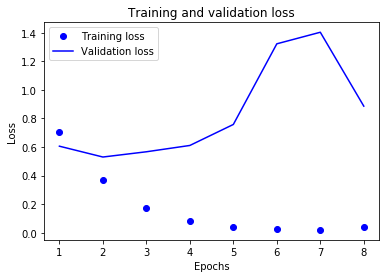

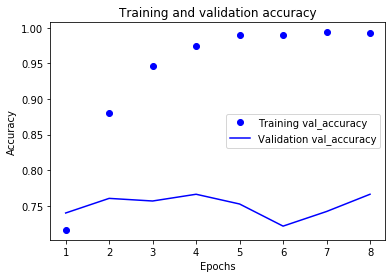

In [15]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

epochs = range(1, len(history_dict['accuracy']) + 1)

plt.figure()
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.figure()
plt.plot(epochs, acc_values, 'bo', label='Training val_accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Validation val_accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

##  Evaluate and predict

In [16]:
accuracy = model.evaluate(x_test, testLabel, verbose=1) 
#  print('Accuracy[0]: %f' % (accuracy[0] * 100))
print('Accuracy: %f' % (accuracy[1] * 100))


# ========== predict test data and write to file: 6-CisBi_Pred_Test.csv ==========================
predict = model.predict_classes(x_test)
predictClass = predict.reshape(-1)

csvTest_path = "News-CIS Data/Predict/6-1-2-BiClsMLP-NewsCIS-Word2Vec512-PredCk.csv"
ckCunt = 0

with open(csvTest_path ,"w", newline='', encoding='utf-8-sig') as csvTest_file:
     writer = csv.writer(csvTest_file)
     writer.writerow(["SeqNO", "Text", "Label", "Predict", "Check"])
     for i in range(0,len(predictClass)):
         ck = ""
         if testLabel[i] != predictClass[i]:
            ck = "Check"
            ckCunt += 1
         writer.writerow([i+1, testTx[i], testLabel[i], predictClass[i], ck])
     writer.writerow(["總測試筆數=",i,"不符筆數=",ckCunt,ckCunt/i])
print("Checked/Total = %d / %d " %(i,ckCunt))

1900/1900 [==============================] - 4s 2ms/step
Accuracy: 76.631582
Checked/Total = 1899 / 444 


##  Predict Verify data and write to file

In [17]:
# ----------- output file可置換成標的議員資料 -----------------------
vfTx_seq = token.texts_to_sequences(vfTx)
vfTx_pad = sequence.pad_sequences(vfTx_seq, maxlen=max_length, padding='post')
predNew = model.predict_classes(vfTx_pad)
predNewClass = predNew.reshape(-1)

csvPredict_path = "News-CIS Data/Predict/6-1-2-BiClsMLP-NewsCIS-Word2Vec512-Predict.csv"
with open(csvPredict_path ,"w", newline='', encoding='utf-8-sig') as csvNew_file:
     writer = csv.writer(csvNew_file)
     writer.writerow(["SeqNO", "Text", "Predict"])
     for i in range(0,len(predNewClass)):
          writer.writerow([i+1, vfTx[i], predNewClass[i]])
print("Total predict records = ", i)

Total predict records =  18629
